# Segmentation of Indian Traffic

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/data.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/images/377/frame28480_leftImg8bit.jpg  
  inflating: /content/data/images/377/frame28699_leftImg8bit.jpg  
  inflating: /content/data/images/377/frame28808_leftImg8bit.jpg  
  inflating: /content/data/images/377/frame29080_leftImg8bit.jpg  
  inflating: /content/data/images/377/frame29271_leftImg8bit.jpg  
  inflating: /content/data/images/377/frame29435_leftImg8bit.jpg  
  inflating: /content/data/images/377/frame29653_leftImg8bit.jpg  
  inflating: /content/data/images/377/frame29817_leftImg8bit.jpg  
  inflating: /content/data/images/377/frame30062_leftImg8bit.jpg  
  inflating: /content/data/images/377/frame30199_leftImg8bit.jpg  
  inflating: /content/data/images/377/frame3039_leftImg8bit.jpg  
  inflating: /content/data/images/377/frame30417_leftImg8bit.jpg  
  inflating: /content/data/images/377/frame30499_leftImg8bit.jpg  
  inflating: /content/data/images/377/frame30608_leftImg8bit.jpg  
  inflating:

In [1]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib

C:\Users\mynam\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\mynam\miniconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\mynam\miniconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [2]:
def return_file_names_df(root_dir):
    
    images_dir="/images"
    json_dir="/mask"
    images_dir_list=os.listdir(root_dir+images_dir)
    json_dir_list=os.listdir(root_dir+json_dir)
    images=[]
    json_file=[]
    for i in images_dir_list:
        image=os.listdir(root_dir+images_dir+os.sep+i)
        for img in image:
            images.append(root_dir+images_dir+os.sep+i+os.sep+img)
    for i in json_dir_list:
        image=os.listdir(root_dir+json_dir+os.sep+i)
        for img in image:
            json_file.append(root_dir+json_dir+os.sep+i+os.sep+img)
    data_df=pd.DataFrame({"image":images,"json":json_file})
    
    return data_df

In [3]:
root_dir="data"

In [4]:
data_df = return_file_names_df(root_dir)
data_df.head()

,image,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [ ]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    unique_labels=[]
    mask=data_df.json
    for i in mask:
        re=open(i)
        g=json.load(re)
        qw=[]
        for x in g['objects']:
            qw.append(x['label'])
        
        for a in qw:
            if a not in unique_labels:
                unique_labels.append(a)
    return unique_labels

In [ ]:
unique_labels = return_unique_labels(data_df)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [ ]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
    
    rt=open(file)
    q=json.load(rt)
    label=[]
    vertexlist=[]
    for i in q["objects"]:
        label.append(i["label"])
    h=q["imgHeight"]
    w=q["imgWidth"]
    for j in q["objects"]:
        d=j["polygon"]
        grh=[]
        for x in d:
            grh.append(tuple(x))
        vertexlist.append(grh)
    return w, h, label, vertexlist

In [ ]:
w,h,label,vertexlist=get_poly("data/mask/201/frame0029_gtFine_polygons.json")

In [ ]:
label

['road',
 'drivable fallback',
 'drivable fallback',
 'drivable fallback',
 'drivable fallback',
 'motorcycle',
 'sky',
 'drivable fallback',
 'curb',
 'motorcycle',
 'motorcycle',
 'building',
 'vegetation',
 'vegetation',
 'obs-str-bar-fallback',
 'billboard',
 'vegetation',
 'building',
 'obs-str-bar-fallback',
 'building',
 'building',
 'obs-str-bar-fallback',
 'building',
 'autorickshaw',
 'billboard',
 'billboard',
 'obs-str-bar-fallback',
 'pole',
 'obs-str-bar-fallback',
 'car',
 'building',
 'obs-str-bar-fallback',
 'truck',
 'person',
 'person',
 'building',
 'building',
 'pole',
 'building',
 'pole',
 'obs-str-bar-fallback',
 'obs-str-bar-fallback',
 'building',
 'pole',
 'building',
 'billboard',
 'billboard',
 'billboard',
 'pole',
 'billboard',
 'billboard',
 'billboard',
 'obs-str-bar-fallback',
 'obs-str-bar-fallback',
 'person',
 'motorcycle',
 'car',
 'obs-str-bar-fallback',
 'motorcycle',
 'truck',
 'motorcycle',
 'person',
 'autorickshaw',
 'car',
 'animal',
 'perso

In [ ]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

In [ ]:
def compute_masks(data_df):
    
    path="data/output/"
    mask_data=[]
    for i in data_df.json:
        j=i.split("/")
        isexist=os.path.isdir("data/output/"+j[2])
        if isexist:
            pass
        else:
            os.makedirs("data/output/"+j[2])
        
        w,h,label,vertexlist=get_poly(i)
        img=Image.new("RGB",(w,h))
        img1=ImageDraw.Draw(img)
        for i in range(len(vertexlist)):
            if len(vertexlist[i])>1:
                img1.polygon(vertexlist[i],fill=label_clr[label[i]])
        img=np.array(img)
        im=Image.fromarray(img[:,:,0])
        name=j[3].split(".")
        im.save(path+j[2]+"/"+name[0]+".png")
        direc=path+j[2]+"/"+name[0]+".png"
        mask_data.append(direc)
    data_df["mask"]=mask_data
    
    return data_df

In [ ]:
data_df = compute_masks(data_df)
data_df.head()

,image,json,mask
0,data/images/359/frame0452_leftImg8bit.jpg,data/mask/359/frame1982_gtFine_polygons.json,data/output/359/frame1982_gtFine_polygons.png
1,data/images/359/frame0182_leftImg8bit.jpg,data/mask/359/frame0182_gtFine_polygons.json,data/output/359/frame0182_gtFine_polygons.png
2,data/images/359/frame1052_leftImg8bit.jpg,data/mask/359/frame2012_gtFine_polygons.json,data/output/359/frame2012_gtFine_polygons.png
3,data/images/359/frame2012_leftImg8bit.jpg,data/mask/359/frame0014_gtFine_polygons.json,data/output/359/frame0014_gtFine_polygons.png
4,data/images/359/frame1952_leftImg8bit.jpg,data/mask/359/frame0452_gtFine_polygons.json,data/output/359/frame0452_gtFine_polygons.png


In [ ]:
#daving the final dataframe to a csv file
data_df.to_csv('preprocessed_data.csv', index=False)

In [ ]:
s=cv2.imread("data/output/201/frame0029_gtFine_polygons.png")

array([[160, 160, 160],
       [160, 160, 160],
       [160, 160, 160],
       ...,
       [160, 160, 160],
       [  0,   0,   0],
       [  0,   0,   0]], dtype=uint8)

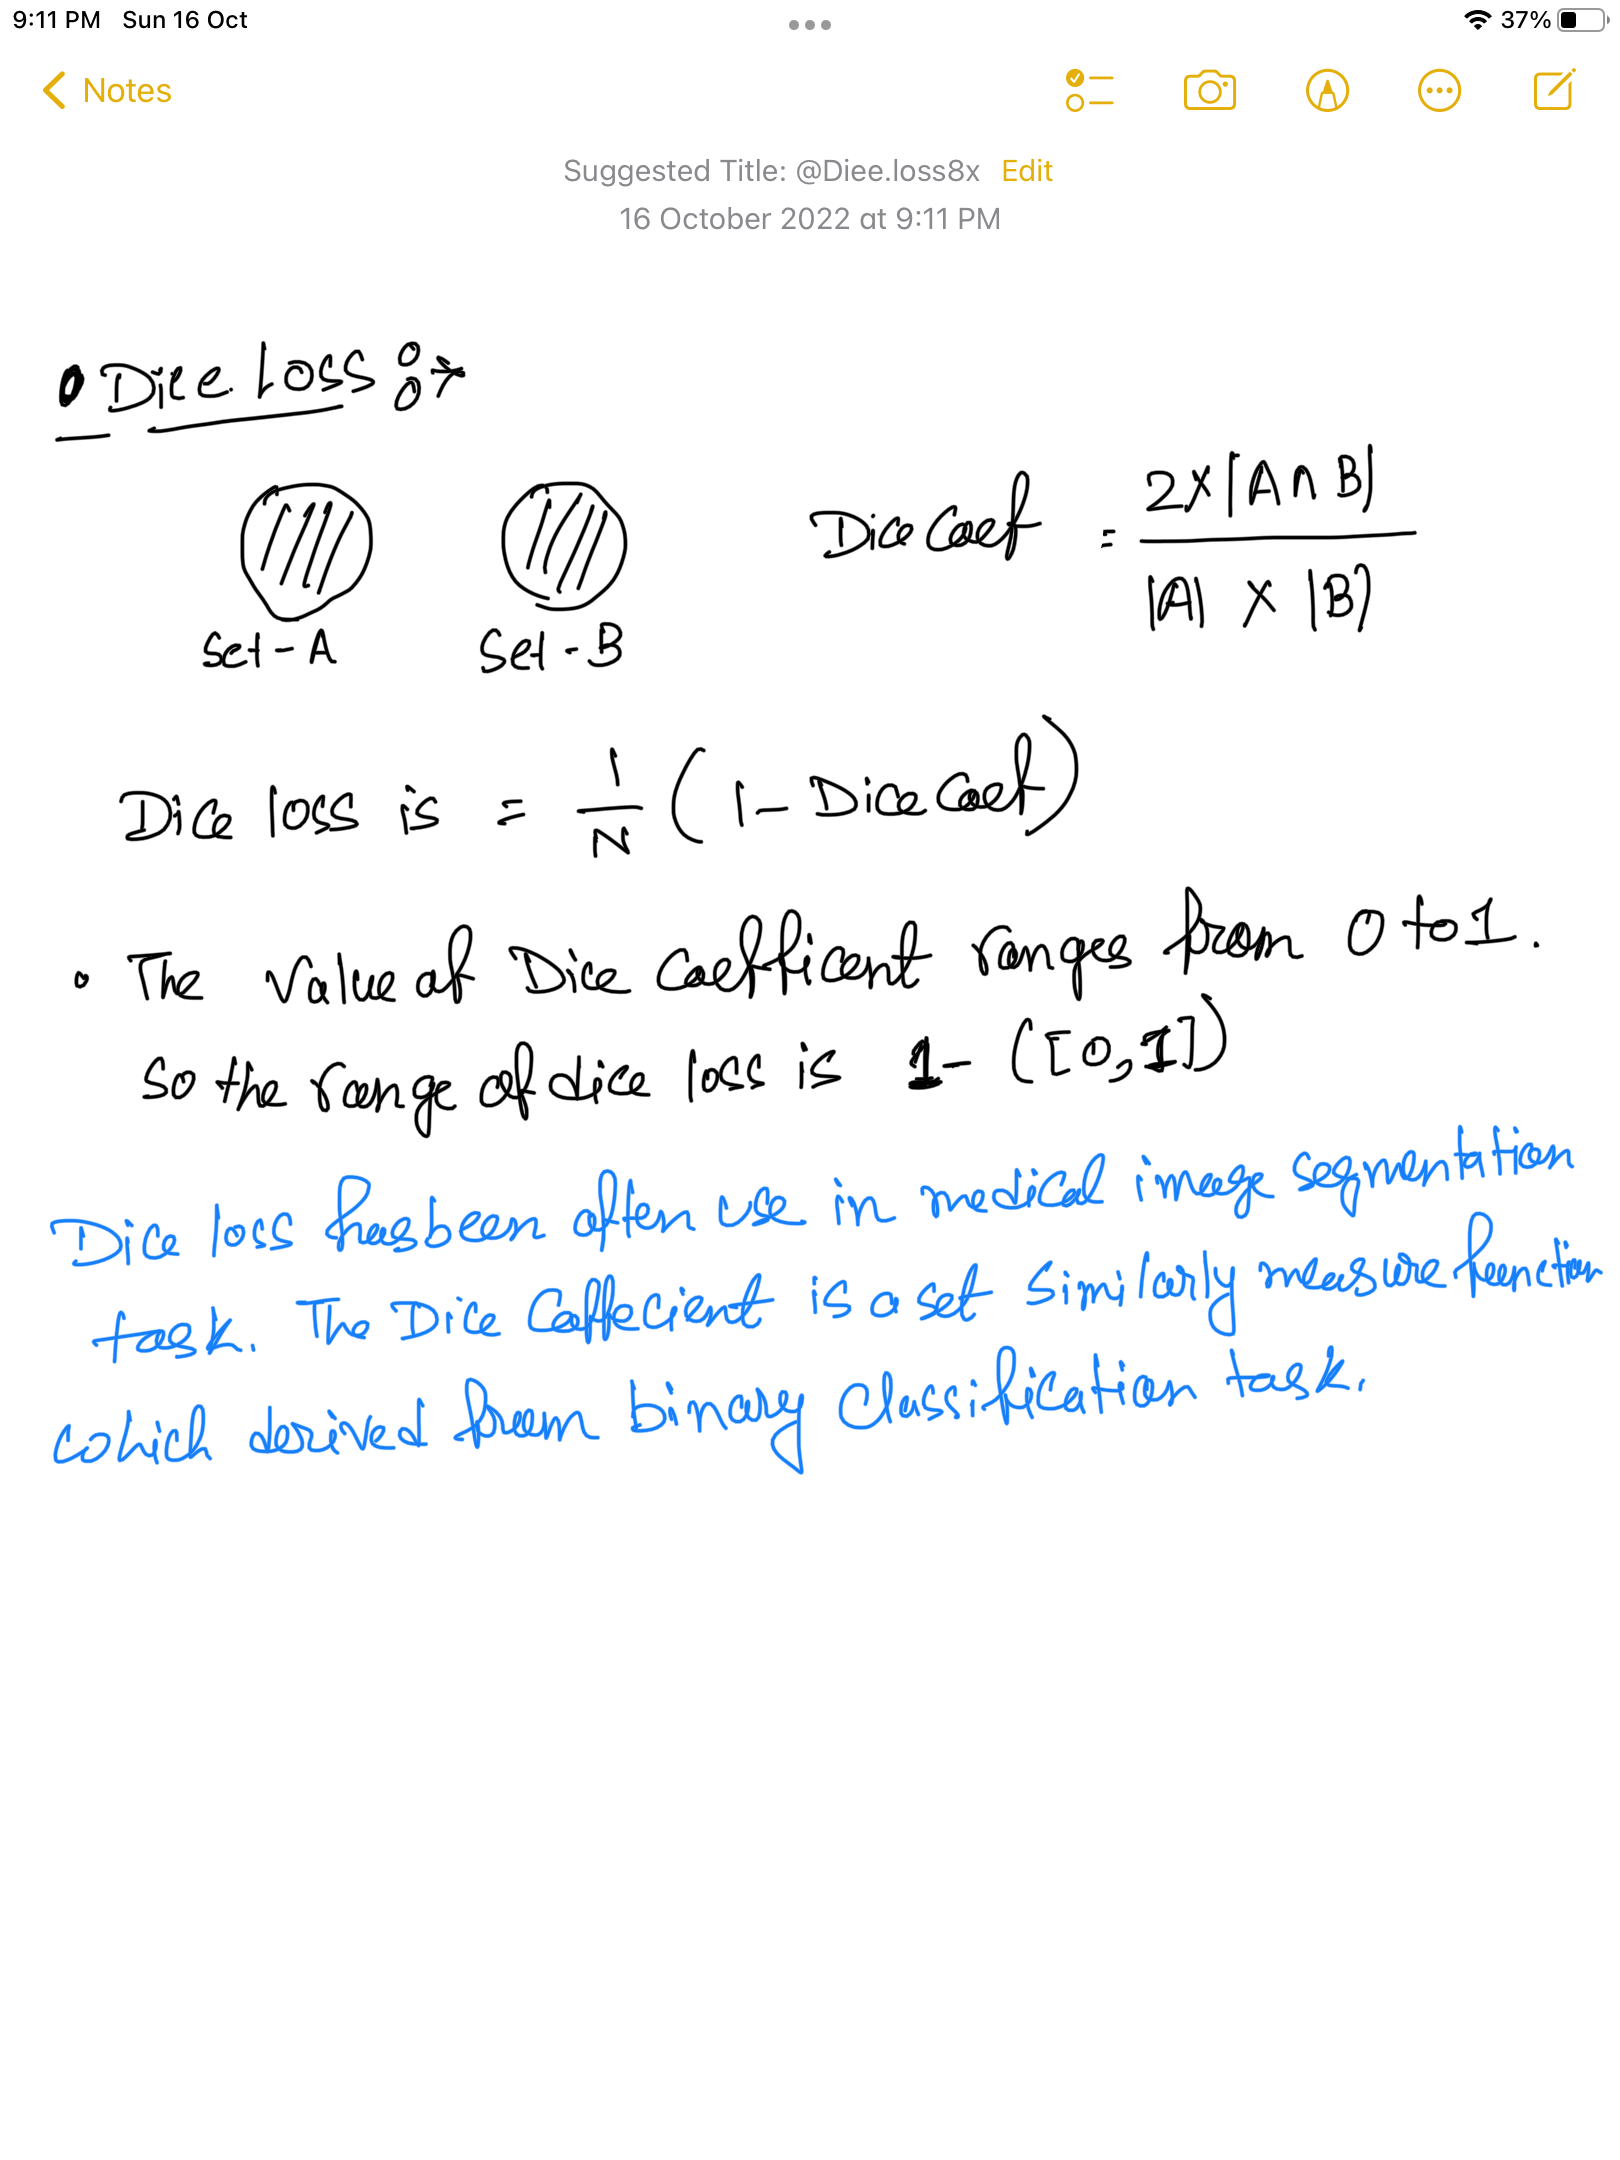

In [9]:
Image(filename='IMG_0034.PNG') 




```
# This is formatted as code
```

# Task 3: Training CANet

* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [14]:
file_names=pd.read_csv('/content/preprocessed_data.csv')

In [16]:
file_names=file_names[['image','mask']]

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(file_names, test_size=0.10, random_state=42)

In [27]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
   


In [28]:
class Dataset:
   
    def __init__(self, file_names,classes,type_data):
        
        self.ids = file_names
        # the paths of images
        self.images_fps = [image_id for image_id in self.ids['image']]
        # the paths of segmentation images
        self.masks_fps = [image_id for image_id in self.ids['mask']]
        # giving labels for each class
        self.class_values = classes
        self.type_data=type_data
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (512,512), cv2.INTER_NEAREST)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (512,512), cv2.INTER_NEAREST)
        
        
        image_masks = [(mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
        if self.type_data=='train':
            a = np.random.uniform()
            if a<0.25:
                image = aug1.augment_image(image)
                image_mask = aug1.augment_image(image_mask)
            elif a<0.5:
                image = aug2.augment_image(image)
                image_mask = aug2.augment_image(image_mask)
            elif a<0.75:
                image = aug3.augment_image(image)
                image_mask = aug3.augment_image(image_mask)
            
            else:
                image = aug4.augment_image(image)
                image_mask = aug4.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=3, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [29]:
CLASSES = list(np.unique(list(label_clr.values())))
train_dataset = Dataset(X_train, classes=CLASSES,type_data='train')
test_dataset = Dataset(X_test, classes=CLASSES,type_data='test')
train_dataloader = Dataloder(train_dataset, batch_size=5, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=5, shuffle=True)

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)


/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [31]:

class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=1, name="conv block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        self.n=name
        self.conv1=Conv2D(filters=self.F1,kernel_size=(1,1),strides=(self.stride,self.stride),kernel_initializer=glorot_uniform(seed=0))
        self.bn1=BatchNormalization()
        self.conv2=Conv2D(filters=self.F2,kernel_size=(self.kernel,self.kernel),strides=(1,1),padding='same',kernel_initializer=glorot_uniform(seed=0))
        self.bn2=BatchNormalization()
        self.conv3=Conv2D(filters=self.F3,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_initializer=glorot_uniform(seed=0))
        self.bn3=BatchNormalization()
        self.conv3_shortcut=Conv2D(filters=self.F3,kernel_size=(3,3),strides=(self.stride,self.stride),padding='same',kernel_initializer=glorot_uniform(seed=0))
        self.bn3_shortcut=BatchNormalization()
    def call(self, X,train):
       
        
        X_shortcut=X
        X = self.conv1(X,training=train)
        X = self.bn1(X,training=train)
        X=Activation('relu')(X)
       
        X = self.conv2(X,training=train)
        X = self.bn2(X,training=train)
        X=Activation('relu')(X) 

        
        X = self.conv3(X,training=train)
        X = self.bn3(X,training=train)

        
        X_short=self.conv3_shortcut(X_shortcut,training=train)
        X_short=self.bn3_shortcut(X_short,training=train)
        X_short=Activation('relu')(X_short)

        X=Add()([X,X_short])
        X=Activation('relu')(X)       



        return X


In [ ]:
class convolutional_block(tf.keras.Model):
    def __init__(self,kernel=3,  filters=[4,4,8], stride=1):
        super().__init__()
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        self.add = Add()
        
        self.conv1 = Conv2D(self.F1,(1,1),strides=(self.stride,self.stride),padding='same'
                            )
        self.BN1 = BatchNormalization(axis=3)


        self.conv2 = Conv2D(self.F2,(self.kernel,self.kernel),strides=(1,1),padding='same'
                            )
        self.BN2 = BatchNormalization(axis=3)

        self.conv3 = Conv2D(self.F3,(self.kernel,self.kernel),strides=(self.stride,self.stride),padding='same',
                            )
        self.BN3 = BatchNormalization(axis=3)

        self.conv4 = Conv2D(self.F3,(1,1),strides=(1,1),padding='same',
                           )
        self.BN4 = BatchNormalization(axis=3)

        self.activation = Activation('relu')
            
    def call(self, X):

        Y = self.conv3(X)
        Y = self.BN3(Y)
        Y = self.activation(Y)

        X = self.conv1(X)
        X = self.BN1(X)
        X = self.activation(X)

        X = self.conv2(X)
        X = self.BN2(X)
        X = self.activation(X)

        X = self.conv4(X)
        X = self.BN4(X)

        X = self.add([X,Y])
        X = self.activation(X)

        return X





In [32]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8]):
        super().__init__()
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        
        self.conv1=Conv2D(filters=self.F1,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_initializer=glorot_uniform(seed=0))
        self.bn1=BatchNormalization()
        self.conv2=Conv2D(filters=self.F2,kernel_size=(self.kernel,self.kernel),strides=(1,1),padding='same',kernel_initializer=glorot_uniform(seed=0))
        self.bn2=BatchNormalization()
        self.conv3=Conv2D(filters=self.F3,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_initializer=glorot_uniform(seed=0))
        self.bn3=BatchNormalization()
        

    def call(self, X,train):
        # write the architecutre that was mentioned above
        X_shortcut=X
        X = self.conv1(X,training=train)
        X = self.bn1(X,training=train)
        X=Activation('relu')(X)
        #layer 2
        X = self.conv2(X,training=train)
        X = self.bn2(X,training=train)
        X=Activation('relu')(X) 
        
        #layer 3
        X = self.conv3(X,training=train)
        X = self.bn3(X,training=train)
        #final in indenty block i will be just adding shortcut
        #and then pass it to activation layer 
        X=Add()([X,X_shortcut])
        X=Activation('relu')(X)

        return X

    
    


In [33]:

class global_flow(tf.keras.layers.Layer):
    def __init__(self, name="global_flow"):
        super().__init__(name=name)
        self.convolution=Conv2D(64,(1,1),activation='relu',padding='same',name='Global_flow_layer')
        self.batch_norm=BatchNormalization()
        self.conv_upSample=tf.keras.layers.UpSampling2D(size=(64,64),interpolation='bilinear')
    def call(self, X,train):
        # implement the global flow operatiom
        X=GlobalAveragePooling2D()(X)
        X=tf.expand_dims(X,axis=1)
        X=tf.expand_dims(X,axis=1)
        X=self.batch_norm(X,training=train)
        X=Activation('relu')(X)
        X=self.convolution(X,training=train)
        X=self.conv_upSample(X,training=train)
        return X


In [34]:

class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)

        self.conv_1=Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'Con_flow_1_conv_1' )
        self.conv_2=Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'Con_flow_1_conv_2')
        self.conv_3=Conv2D(64, (1, 1), activation = 'relu', padding = 'same', name = 'Con_flow_1_conv_3' )
        self.conv_4=Conv2D(64, (1, 1), activation = 'relu', padding = 'same', name = 'Con_flow_1_conv_4' )
        self.conv_upSample_1=tf.keras.layers.UpSampling2D(size=(2,2),interpolation="bilinear")
        self.conv_5=Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'Con_flow_2_conv_1' )
        self.conv_6=Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'Con_flow_2_conv_2' )
        self.conv_7=Conv2D(64, (1, 1), activation = 'relu', padding = 'same', name = 'Con_flow_2_conv_3')
        self.conv_8=Conv2D(64, (1, 1), activation = 'relu', padding = 'same', name = 'Con_flow_2_conv_4' )
        self.conv_upSample_2=tf.keras.layers.UpSampling2D(size=(2,2),interpolation="bilinear")
        self.conv_9=Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'Con_flow_3_conv_1')
        self.conv_10=Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'Con_flow_3_conv_2')
        self.conv_11=Conv2D(64, (1, 1), activation = 'relu', padding = 'same', name = 'Con_flow_3_conv_3' )
        self.conv_12=Conv2D(64, (1, 1), activation = 'relu', padding = 'same', name = 'Con_flow_3_conv_4' )
        self.conv_upSample_3=tf.keras.layers.UpSampling2D(size=(2,2),interpolation="bilinear")

    def call(self, X,train):
        
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        
        # implement the context flow as mentioned in the above cell
        concat_1 =concatenate([INP,FLOW],axis=3)
 
        Con_flow_1a = AveragePooling2D((2, 2),  (2, 2), name = 'CF1_pool' )(concat_1)
        Con_flow_1a = self.conv_1(Con_flow_1a,training=train)
        Con_flow_1a = self.conv_2(Con_flow_1a,training=train)

        Con_flow_1b = self.conv_3(Con_flow_1a,training=train)
        Con_flow_1b = Activation('relu')(Con_flow_1b)
        Con_flow_1b = self.conv_4(Con_flow_1b,training=train)
        Con_flow_1b = Activation('sigmoid')(Con_flow_1b)

        Con_flow_1c = Multiply()([Con_flow_1a , Con_flow_1b])
        Con_flow_1a = Add()([Con_flow_1a,Con_flow_1c])
        Con_flow_1a= self.conv_upSample_1(Con_flow_1a) 

        #second contextflow
        
        concat_2= concatenate([INP,Con_flow_1a],axis=3)
        
        Con_flow_2a= AveragePooling2D((2, 2), (2, 2), name = 'CF2_pool' )(concat_2)
        Con_flow_2a = self.conv_5(Con_flow_2a,training=train)
        Con_flow_2a = self.conv_6(Con_flow_2a,training=train)

        Con_flow_2b = self.conv_7(Con_flow_2a,training=train)
        Con_flow_2b= Activation('relu')(Con_flow_2b)  
        Con_flow_2b = self.conv_8(Con_flow_2b,training=train)
        Con_flow_2b=  Activation('sigmoid')(Con_flow_2b)

        Con_flow_2c= Multiply()([Con_flow_2a, Con_flow_2b])
        Con_flow_2a = Add()([Con_flow_2c,Con_flow_2a])
        Con_flow_2a = self.conv_upSample_2(Con_flow_2a)

        
        #third cf
        concat_3 = concatenate([INP,Con_flow_2a],axis=3)
        Con_flow_3a = AveragePooling2D((2, 2),  (2, 2), name = 'CF3_pool')(concat_3)
        Con_flow_3a = self.conv_9(Con_flow_3a,training=train)
        Con_flow_3a = self.conv_10(Con_flow_3a,training=train)

        Con_flow_3b = self.conv_11(Con_flow_3a,training=train)
        Con_flow_3b = Activation('relu')(Con_flow_3b)
        Con_flow_3b = self.conv_12(Con_flow_3b,training=train)
        Con_flow_3b = Activation('sigmoid')(Con_flow_3b)

        Con_flow_3c=  Multiply()([Con_flow_3a,Con_flow_3b])
        Con_flow_3a = Add()([Con_flow_3c,Con_flow_3a])
        Con_flow_3a = self.conv_upSample_3(Con_flow_3a)


        X=Add()([FLOW,Con_flow_1a,Con_flow_2a,Con_flow_3a])
        return X

In [35]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
        self.conv_1=Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'FSM_conv_1')
        self.conv_2=Conv2D(64, (1, 1), activation = 'relu' ,name = 'FSM_conv_1')
        self.bn=BatchNormalization()
        self.conv_upSample=tf.keras.layers.UpSampling2D(size=(2,2),interpolation="bilinear")
    def call(self, X,train):
        # implement the FSM modules based on image in the above cells
        FSM_conv_1 = self.conv_1(X,training=train)
        FSM_conv_2= GlobalAveragePooling2D()(FSM_conv_1)
        FSM_conv_2=tf.expand_dims(FSM_conv_2,axis=1)
        FSM_conv_2=tf.expand_dims(FSM_conv_2,axis=1)
        #FSM_conv_2=Reshape((1,1,64))(FSM_conv_2)
        FSM_conv_2 = self.conv_2(FSM_conv_2,training=train)
        FSM_conv_2 = self.bn(FSM_conv_2,training=train)
        FSM_conv_2= Activation('sigmoid')(FSM_conv_2)
        
        FSM_Conv_T = Multiply()([FSM_conv_1,FSM_conv_2]) 
        FSM_Conv_T=self.conv_upSample(FSM_Conv_T)
        return FSM_Conv_T

In [36]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self,name='Ada_glo_conv_net'):
        super().__init__(name=name)
        self.conv_1=Conv2D(64, (7, 1), activation = 'relu', padding = 'same', name = 'AGCN_conv_1' )
        self.conv_2=Conv2D(64, (1, 7), activation = 'relu', padding = 'same', name = 'AGCN_conv_2' )
        self.conv_3=Conv2D(64, (1, 7), activation = 'relu', padding = 'same', name = 'AGCN_conv_3' )
        self.conv_4=Conv2D(64, (7, 1), activation = 'relu', padding = 'same', name = 'AGCN_conv_4' )
        self.conv_5=Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'AGCN_conv_5' )        
    def call(self, X,train):
        # please implement the above mentioned architecture
        agcn_1=self.conv_1(X,training=train)
        agcn_1=self.conv_2(agcn_1,training=train)

        agcn_2=self.conv_3(X,training=train)
        agcn_2=self.conv_4(agcn_2,training=train)

        add=Add()([agcn_1,agcn_2])
        agcn_3=self.conv_5(add,training=train)
        X=Add()([add,agcn_3])


        return X

In [37]:
X_input = Input(shape=(512,512,3))

# Stage 1
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)
print(X.shape)



(None, 256, 256, 64)


In [38]:
conv_1=convolutional_block(kernel=3,filters=[4,4,8],stride=2,name='conv_block_layer_1')
identity_1=identity_block(kernel=3,filters=[4,4,8])
conv_2=convolutional_block(kernel=3,filters=[8,8,16],stride=2,name='conv_block_layer_2')
identity_2_a=identity_block(kernel=3,filters=[8,8,16])
identity_2_b=identity_block(kernel=3,filters=[8,8,16])

conv_3=convolutional_block(kernel=3,filters=[16,16,32],stride=1,name='conv_block_layer_3')
identity_3_a=identity_block(kernel=3,filters=[16,16,32])
identity_3_b=identity_block(kernel=3,filters=[16,16,32])
identity_3_c=identity_block(kernel=3,filters=[16,16,32])

conv_4=convolutional_block(kernel=3,filters=[32,32,64],stride=1,name='conv_block_layer_4')
identity_4_a=identity_block(kernel=3,filters=[32,32,64])
identity_4_b=identity_block(kernel=3,filters=[32,32,64])
identity_4_c=identity_block(kernel=3,filters=[32,32,64])
identity_4_d=identity_block(kernel=3,filters=[32,32,64])

Global_Flow=global_flow(name='global_flow')
Context_Flow=context_flow(name='context_flow')
FSM=fsm(name='feature_selection_module')
Ada_glo_con_net=agcn(name='Ada_glo_conv_net')


In [39]:
X_input = Input(shape=(512,512,3))

# Stage 1
X = Conv2D(64, (3, 3), name='convol1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization( name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)
#1 conv block and 1 identity block
conv_block_1=conv_1(X,True)
iden_block_1=identity_1(conv_block_1,True)
#1 conv block and 2 identity block
conv_block_2=conv_2(iden_block_1,True)
iden_block_2_a=identity_2_a(conv_block_2,True)
iden_block_2_b=identity_2_b(iden_block_2_a,True)
#1 conv block and 3 identity block
conv_block_3=conv_3(iden_block_2_b,True)
iden_block_3_a=identity_3_a(conv_block_3,True)
iden_block_3_b=identity_3_b(iden_block_3_a,True)
iden_block_3_c=identity_3_c(iden_block_3_b,True)
#1 conv block and 4 identity block
conv_block_4=conv_4(iden_block_3_c,True)
iden_block_4_a=identity_4_a(conv_block_4,True)
iden_block_4_b=identity_4_b(iden_block_4_a,True)
iden_block_4_c=identity_4_c(iden_block_4_b,True)
iden_block_4_d=identity_4_d(iden_block_4_c,True)
#using indentity blocck output in global flow architecture 
Glob_flow=Global_Flow(iden_block_4_d,True)
#content_flow
con_flow=Context_Flow([iden_block_4_d,Glob_flow],True)

feat_selec=FSM(con_flow,True)
ada_global=Ada_glo_con_net(conv_block_1,True)
conc=concatenate([feat_selec,ada_global],name="conc_fdm_agcn")
conv_final=Conv2D(21,(3,3),activation="relu",padding="same")(conc)
upsample = UpSampling2D((4,4), interpolation = 'bilinear')(conv_final)
Final=Activation("softmax")(upsample)




In [41]:

model = Model(inputs = X_input, outputs = Final)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 convol1 (Conv2D)               (None, 512, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 512, 512, 64  256         ['convol1[0][0]']                
                                )                                                           

In [42]:

import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet


optim = tf.keras.optimizers.Adam(0.001)

total_loss = sm.losses.cce_dice_loss 

model.compile(optim, total_loss, metrics=[iou_score])

In [43]:
CLASSES = list(np.unique(list(label_clr.values())))
train_dataset = Dataset(X_train, classes=CLASSES,type_data='train')
test_dataset = Dataset(X_test, classes=CLASSES,type_data='test')
train_dataloader = Dataloder(train_dataset, batch_size=8, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=8, shuffle=True)

In [45]:
aug1 = iaa.Fliplr(1)
aug2 = iaa.Flipud(1)
aug3 = iaa.Emboss(alpha=(1), strength=1)
aug4 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))

In [48]:
# Dataset for train images
BATCH_SIZE=8
print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, 21)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.001,patience=2),
]

(8, 512, 512, 3)
(8, 512, 512, 21)


In [49]:
history = model.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=25,\
                              validation_data=test_dataloader,callbacks=callbacks, )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/25
450/450 [==============================] - 618s 1s/step - loss: 0.8577 - iou_score: 0.1426 - val_loss: 0.8325 - val_iou_score: 0.1713 - lr: 0.0010
Epoch 2/25
450/450 [==============================] - 605s 1s/step - loss: 0.8270 - iou_score: 0.1636 - val_loss: 0.8066 - val_iou_score: 0.1872 - lr: 0.0010
Epoch 3/25
450/450 [==============================] - 600s 1s/step - loss: 0.8013 - iou_score: 0.1822 - val_loss: 0.7802 - val_iou_score: 0.2024 - lr: 0.0010
Epoch 4/25
450/450 [==============================] - 605s 1s/step - loss: 0.7882 - iou_score: 0.1907 - val_loss: 0.7653 - val_iou_score: 0.2159 - lr: 0.0010
Epoch 5/25
450/450 [==============================] - 600s 1s/step - loss: 0.7807 - iou_score: 0.1961 - val_loss: 0.7624 - val_iou_score: 0.2174 - lr: 0.0010
Epoch 6/25
450/450 [==============================] - 593s 1s/step - loss: 0.7653 - iou_score: 0.2074 - val_loss: 0.7484 - val_iou_score: 0.2269 - lr: 0.0010
Epoch 7/25
450/450 [==============================] 

In [50]:
images_fps = [image_id for image_id in file_names['image']]
        # the paths of segmentation images
masks_fps = [image_id for image_id in file_names['mask']]

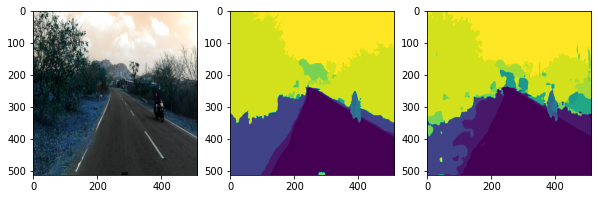

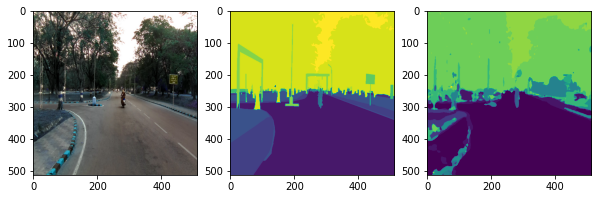

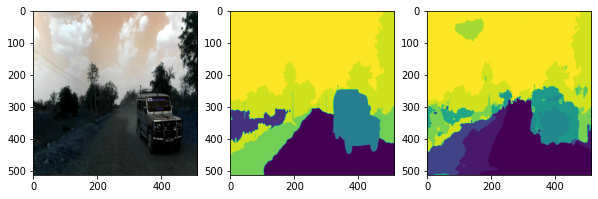

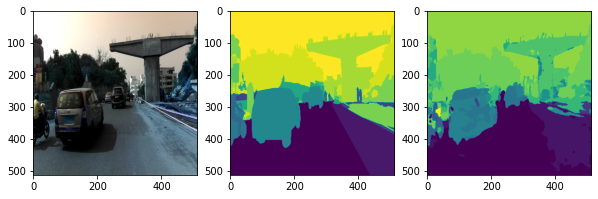

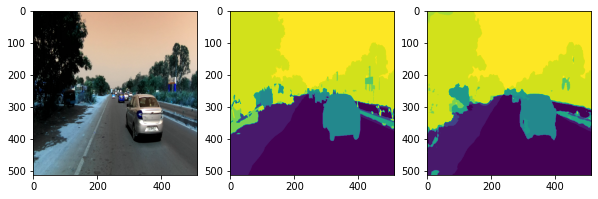

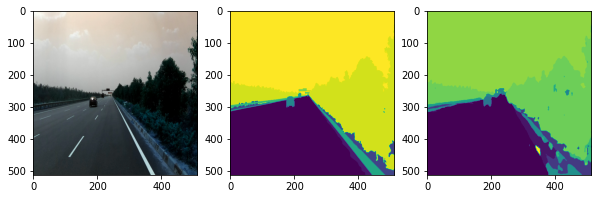

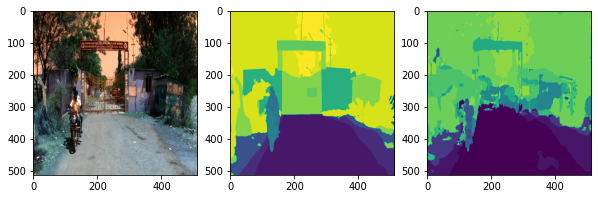

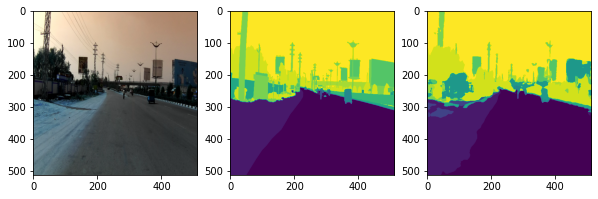

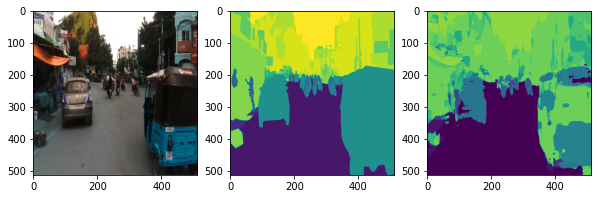

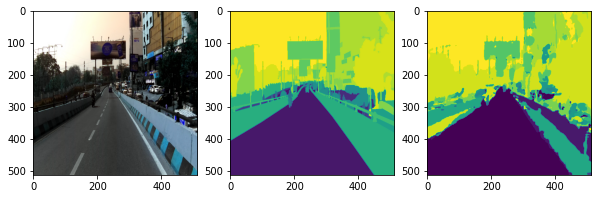

In [53]:
for j,i in enumerate(X_test.values.tolist()[0:10]):
        image = cv2.imread(i[0], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (512,512), cv2.INTER_NEAREST)
        mask  = cv2.imread(i[1], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (512,512), cv2.INTER_NEAREST)
        predicted=model(image[np.newaxis,:,:,:])
        pred=tf.argmax(predicted,axis=-1)
        plt.figure(figsize=(10,6))
        plt.subplot(131)
        plt.imshow(image)
        plt.subplot(132)
        plt.imshow(mask)
        plt.subplot(133)
        # for t in range(0,10):
        plt.imshow(pred[0,:,:])
        plt.show()
